# Exploratory Data Analysis

The data originates from the [kaggle copetition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/overview)

<p align="center">
    <img src="img/description.png"  width="80%" height="20%">
</p>

### Dataset Description
File descriptions
 * train.csv - the training set.
 * test.csv - the test set.
 * data_description.txt - full description of each column, originally prepared by Dean De Cock but lightly edited to match the column names used here.

 #### EDA:

 **Target Variable**
 
The variable we aim to predict is `SalePrice`.

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro  
from statsmodels.stats.outliers_influence import variance_inflation_factor
from plot_tools import plot_distribution, plot_corration_map, PlotRelations
from bayesian_opt import Optimizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from skopt.space import Integer, Real, Categorical

/var/folders/0m/mtf6psc91_l02bjt_n2nd7bh0000gn/T/ipykernel_6558/4000899093.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [2]:
df = pd.read_csv('data/train.csv')
display(df.head())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_target = df[['SalePrice']]
df_features = df.drop(['Id', 'SalePrice'], axis=1)

### Feature engineering

First, let's examine the missing data and input it accordingly.

In [4]:
def get_missing(X: pd.DataFrame) -> pd.DataFrame:
    missing_rate = (X.isnull().sum() / len(X)) * 100
    missing_rate = missing_rate.drop(
        missing_rate[missing_rate == 0].index).sort_values(ascending=False)[:30]
    missing_data = pd.DataFrame({'Missing Ratio': missing_rate})
    return missing_data

In [5]:
get_missing(df_target)

,Missing Ratio


In [6]:
missing_data = get_missing(df_features)
display(missing_data.head(10))

,Missing Ratio
PoolQC,99.520548
MiscFeature,96.301370
Alley,93.767123
Fence,80.753425
MasVnrType,59.726027
FireplaceQu,47.260274
LotFrontage,17.739726
GarageType,5.547945
GarageYrBlt,5.547945
GarageFinish,5.547945


Alley: Type of alley access to property

* NA: 	No alley access
		
BsmtQual: Evaluates the height of the basement

* NA:	No Basement
		
BsmtCond: Evaluates the general condition of the basement

* NA:	No Basement
	
BsmtExposure: Refers to walkout or garden level walls

* NA:	No Basement
	
BsmtFinType1: Rating of basement finished area

* NA:	No Basement
		
BsmtFinType2: Rating of basement finished area (if multiple types)

* NA:	No Basement

FireplaceQu: Fireplace quality
* NA:	No Fireplace
		
GarageType: Garage location
* NA:	No Garage
	
GarageFinish: Interior finish of the garage
* NA:	No Garage

GarageQual: Garage quality
* NA:	No Garage
		
GarageCond: Garage condition
* NA:	No Garage

PoolQC: Pool quality
* NA:	No Pool
		
Fence: Fence quality
* NA:	No Fence
	
MiscFeature: Miscellaneous feature not covered in other categories
* NA:	None



In [7]:
variables_where_null_is_0 = [
                'BsmtQual', 'BsmtCond', 'BsmtExposure', 
                'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
                'GarageType', 'GarageFinish', 'GarageQual', 
                'GarageCond', 'PoolQC', 'Fence'
            ]
values = {"Functional": "Typ", 
          "Alley": "None", 
          "MasVnrType": "None", 
          "MiscFeature": "no_misc_feature", 
          **{v:0 for v in variables_where_null_is_0}}
df_features.fillna(value=values, inplace=True)

In [8]:
missing_data = get_missing(df_features)
display(missing_data.head(10))

,Missing Ratio
LotFrontage,17.739726
GarageYrBlt,5.547945
MasVnrArea,0.547945
Electrical,0.068493


In [9]:
numeric_feats = df_features.dtypes[df_features.dtypes != "object"].index

In [10]:
df_features = pd.get_dummies(df_features)
df_features = df_features.fillna(df_features.mean())
missing_data = get_missing(df_features)
display(missing_data.head(10))

,Missing Ratio


### Target

We're going to check the distribution of the target variable and observe its asymmetry. However, for now, we won't perform any transformations. Then we will fit two models: Lasso and Random Forest.

Skewness: 1.882876


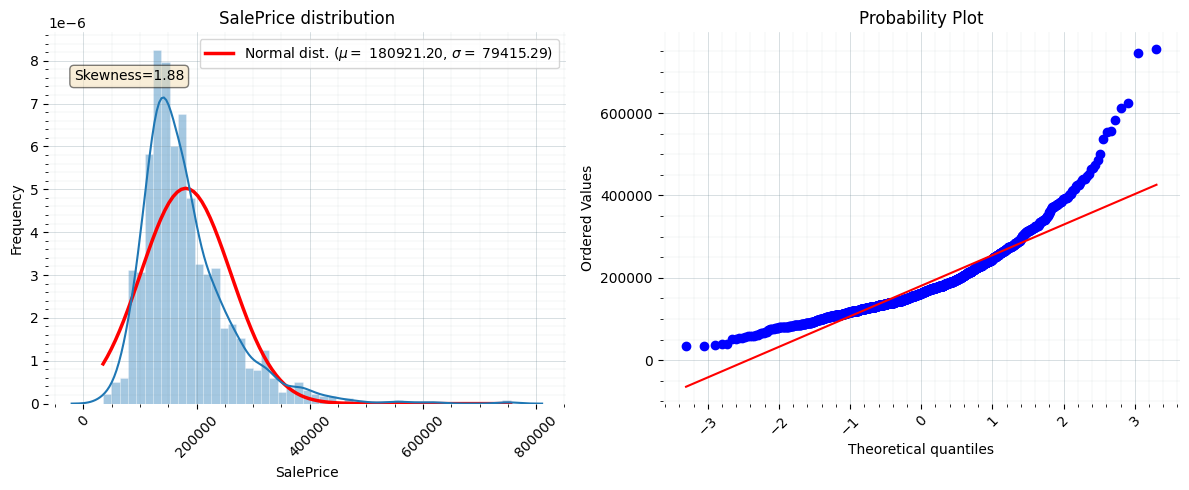

In [11]:
print("Skewness: %f" % df_target['SalePrice'].skew())
plot_distribution(df_target, 'SalePrice')

(1168, 302) (292, 302) (1168,) (292,)
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 620902055.0649436
Best params: {'alpha': 0.0}


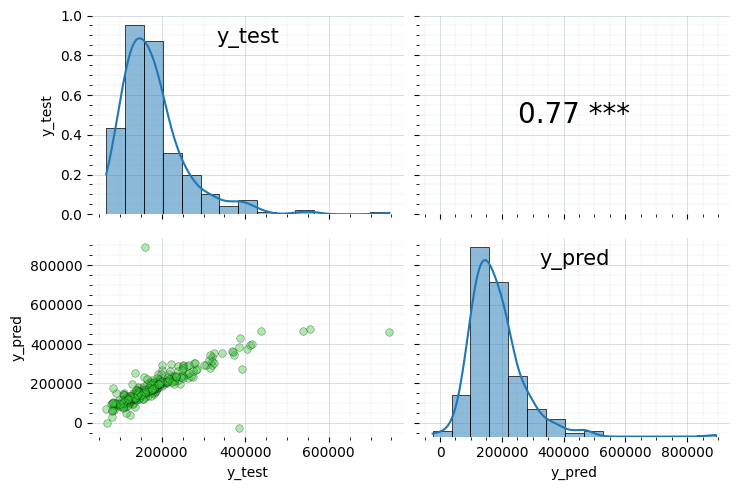

Test accuracy -> cor: 0.7747, mse: 3382109599.0223
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 662316216.9238787
Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1}


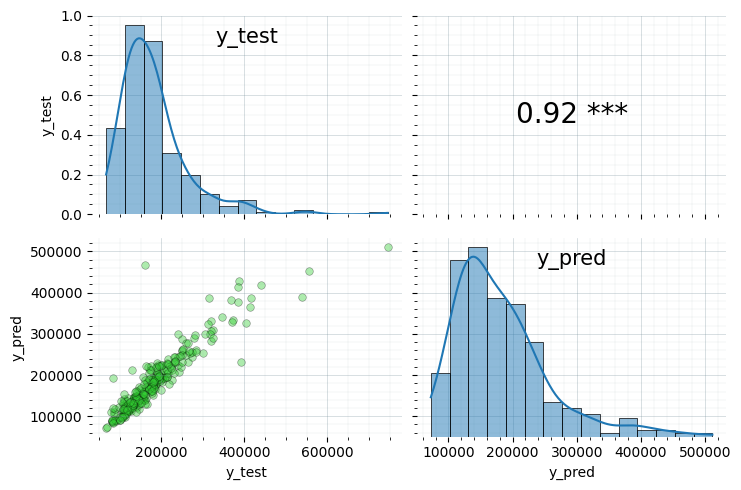

Test accuracy -> cor: 0.9155, mse: 1122063099.4573


In [12]:
warnings.simplefilter("ignore", UserWarning)

y = df_target['SalePrice'].astype(float)
X = df_features.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
dict_models = {
'lasso': {
    'model': Lasso(),
    'space': [
        Real(0, 0.02, name='alpha'),
    ]
},

'rf': {
    'space': [
                Integer(100, 1000, name='n_estimators'),
                Integer(2, 100, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf')
                ],
    'model': RandomForestRegressor()}
}

for model in dict_models:
    model_name = model
    space = dict_models[model]['space']
    model = dict_models[model]['model']
    optimizer = Optimizer(space=space, model=model,
                            model_name=model_name, n_calls=20)

    optimizer.find_optimal_params(X=X_train, y=y_train)
    best_model = optimizer.best_model.fit(X_train, y_train.ravel())
    y_pred = best_model.predict(X_test)
    plot_rel = PlotRelations(pd.DataFrame({'y_test': y_test, 'y_pred': y_pred}), f'./pairplot_{model_name}.png')
    plot_rel.plot_graph()
    print(f"Test accuracy -> cor: {pearsonr(y_pred, y_test)[0]:.4f}, mse: {np.mean((y_pred - y_test)**2):.4f}")


#### Correlation map

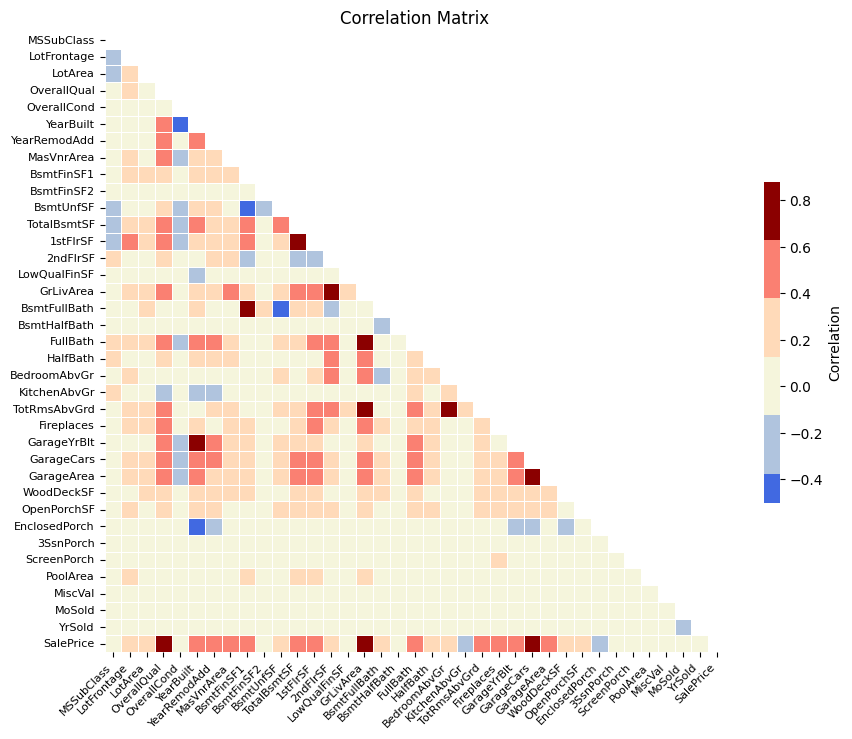

In [13]:
vars = list(numeric_feats)
vars.append('SalePrice')
plot_corration_map(pd.concat([df_features, df_target], axis=1)[vars])

Variance inflation factor, VIF, for one exogenous variable

The variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable, is added to the linear regression. It is a measure for multicollinearity of the design matrix.

One recommendation is that if VIF is greater than 5, then the explanatory variable is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

In [14]:
vif_data = pd.DataFrame()
vif_data["feature"] = numeric_feats
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_features[numeric_feats].values, i)
                          for i in range(len(df_features[numeric_feats].columns))]
  
display(vif_data)

/Users/cristianooliveira/Documents/eda/.venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,MSSubClass,4.648278e+00
1,LotFrontage,1.746100e+01
2,LotArea,2.647732e+00
3,OverallQual,6.661049e+01
4,OverallCond,4.165451e+01
5,YearBuilt,2.137223e+04
6,YearRemodAdd,2.240954e+04
7,MasVnrArea,1.854573e+00
8,BsmtFinSF1,inf
9,BsmtFinSF2,inf


In [15]:
shapiro_test = stats.shapiro(df_target['SalePrice'])
print(f'H0: The data was drawn from a normal distribution. If pvalue > 0.05, we cannot reject the null hypothesis.')
print(f'Shapiro Test: shapiro.statistic = {shapiro_test.statistic:.4f}, shapiro.pvalue = {shapiro_test.pvalue:.4f}')

H0: The data was drawn from a normal distribution. If pvalue > 0.05, we cannot reject the null hypothesis.
Shapiro Test: shapiro.statistic = 0.8697, shapiro.pvalue = 0.0000


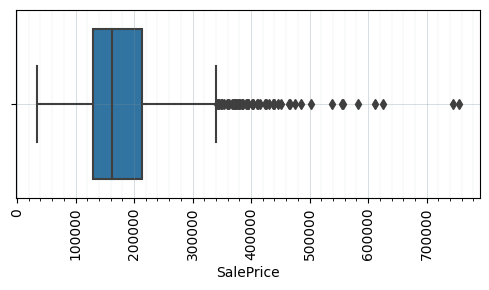

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(x=df_target['SalePrice'], ax=ax)
ax.grid(which = "major", axis='both', color='#758D99', zorder=1, linewidth = 0.5, alpha = 0.4,linestyle='-')
ax.grid(which = "minor", axis='both', color='#758D99', zorder=1, linewidth = 0.3, alpha = 0.2,linestyle='-')
ax.minorticks_on()
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

As we can observe, Random Forest demonstrates superior performance compared to Lasso. Despite our target data initially following a normal distribution, there is multicollinearity among our features. Consequently, employing Ordinary Least Squares (OLS) would not be a suitable option, even though the best Lasso model found has an alpha value of zero. Lasso effectively addresses multicollinearity through regularization.

To enhance the accuracy of Lasso, we will explore a data transformation approach, once the skewness of target variable is equal 1.882876.

In [17]:
df_target.loc[:,'LogSalePrice'] = np.log1p(df_target['SalePrice'].values)

/var/folders/0m/mtf6psc91_l02bjt_n2nd7bh0000gn/T/ipykernel_6558/2508633438.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target.loc[:,'LogSalePrice'] = np.log1p(df_target['SalePrice'].values)


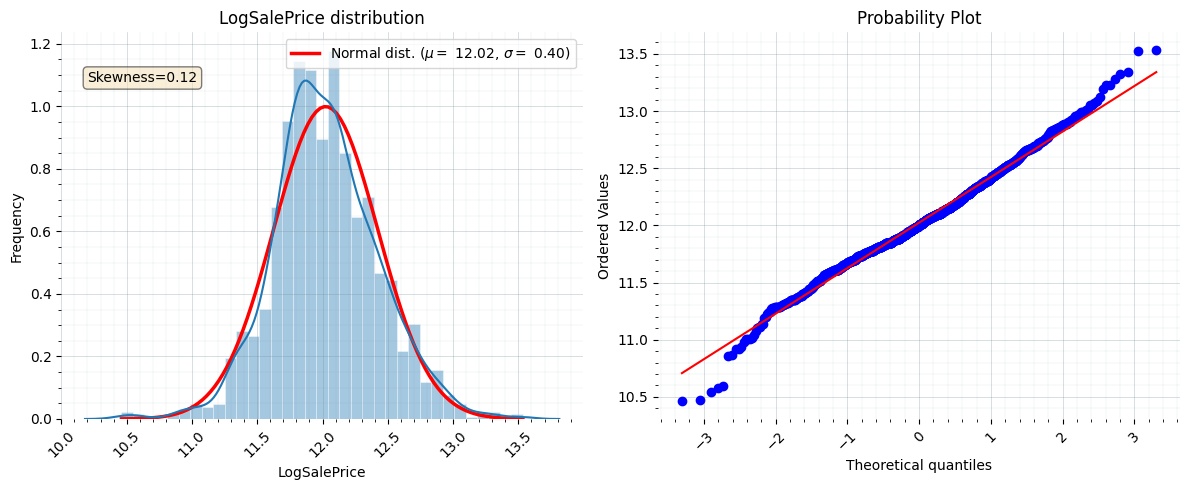

H0: The data was drawn from a normal distribution. If pvalue > 0.05, we cannot reject the null hypothesis.
Shapiro Test: shapiro.statistic = 0.9912, shapiro.pvalue = 0.000000


In [28]:
# plot_distribution(df_target, 'LogSalePrice')
# shapiro_test = stats.shapiro(df_target['LogSalePrice'])
# print(f'H0: The data was drawn from a normal distribution. If pvalue > 0.05, we cannot reject the null hypothesis.')
# print(f'Shapiro Test: shapiro.statistic = {shapiro_test.statistic:.4f}, shapiro.pvalue = {shapiro_test.pvalue:.6f}')

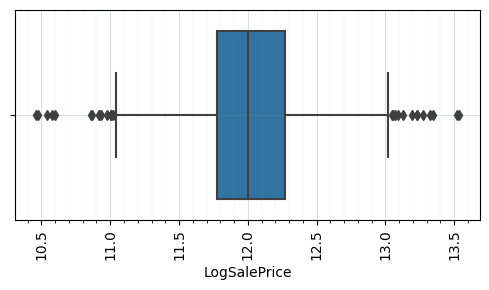

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.boxplot(x=df_target['LogSalePrice'], ax=ax)
ax.grid(which = "major", axis='both', color='#758D99', zorder=1, linewidth = 0.5, alpha = 0.4,linestyle='-')
ax.grid(which = "minor", axis='both', color='#758D99', zorder=1, linewidth = 0.3, alpha = 0.2,linestyle='-')
ax.minorticks_on()
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [20]:
print("Skewness: %f" % df_target['LogSalePrice'].skew())

Skewness: 0.121347


### Modeling

In [21]:
warnings.simplefilter("ignore", UserWarning)
y = df_target['LogSalePrice'].astype(float)
X = df_features.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
dict_models = {
'lasso': {
    'model': Lasso(),
    'space': [
        Real(0, 0.02, name='alpha'),
    ]
},

'rf': {
    'space': [
                Integer(100, 1000, name='n_estimators'),
                Integer(2, 100, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf')
                ],
    'model': RandomForestRegressor()}
}

for model in dict_models:
    model_name = model
    space = dict_models[model]['space']
    model = dict_models[model]['model']
    optimizer = Optimizer(space=space, model=model,
                            model_name=model_name, n_calls=20)

    optimizer.find_optimal_params(X=X_train, y=y_train)
    best_model = optimizer.best_model.fit(X_train, y_train.ravel())
    y_pred = best_model.predict(X_test)
    print(f"Test accuracy -> cor: {pearsonr(np.expm1(y_pred), np.expm1(y_test))[0]:.4f}, mse: {np.mean((y_pred - y_test)**2):.4f}")


(1168, 302) (292, 302) (1168,) (292,)
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 0.014125085987874627
Best params: {'alpha': 0.0011342595463488638}
Test accuracy -> cor: 0.4515, mse: 0.0401
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 0.01915727311824845
Best params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1}
Test accuracy -> cor: 0.9233, mse: 0.0189


### Feature engineering

Now let's examine the skewness of our features and apply a transformation to specific variables.

In [22]:
skewed_feats = df_features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.sort_values(by=['Skew'], ascending=False).head(10))

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [23]:
skewed_feats = df_features[numeric_feats].apply(
    lambda x: skew(x.dropna()))  # compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
df_features[skewed_feats] = np.log1p(df_features[skewed_feats])

In [24]:

skewed_feats = df_features[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
display(skewness.sort_values(by=['Skew'], ascending=False).head(10))

,Skew
PoolArea,14.348342
3SsnPorch,7.727026
LowQualFinSF,7.452650
MiscVal,5.165390
BsmtHalfBath,3.929022
KitchenAbvGr,3.865437
ScreenPorch,3.147171
BsmtFinSF2,2.521100
EnclosedPorch,2.110104
OverallCond,0.692355


In [25]:
warnings.simplefilter("ignore", UserWarning)
y = df_target['LogSalePrice'].astype(float)
X = df_features.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=0)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
dict_models = {
'lasso': {
    'model': Lasso(),
    'space': [
        Real(0, 0.02, name='alpha'),
    ]
},

'rf': {
    'space': [
                Integer(100, 1000, name='n_estimators'),
                Integer(2, 100, name='min_samples_split'),
                Integer(1, 10, name='min_samples_leaf')
                ],
    'model': RandomForestRegressor()}
}

for model in dict_models:
    model_name = model
    space = dict_models[model]['space']
    model = dict_models[model]['model']
    optimizer = Optimizer(space=space, model=model,
                            model_name=model_name, n_calls=20)

    optimizer.find_optimal_params(X=X_train, y=y_train)
    best_model = optimizer.best_model.fit(X_train, y_train.ravel())
    y_pred = best_model.predict(X_test)
    print(f"Test accuracy -> cor: {pearsonr(np.expm1(y_pred), np.expm1(y_test))[0]:.4f}, mse: {np.mean((y_pred - y_test)**2):.4f}")


(1168, 302) (292, 302) (1168,) (292,)
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 0.013536651943483215
Best params: {'alpha': 0.0013912031696438143}
Test accuracy -> cor: 0.8379, mse: 0.0227
Wait: Finding the best parameters .....
Otimization done ...
Trainin acuracy: 0.019222092038530685
Best params: {'n_estimators': 267, 'min_samples_split': 2, 'min_samples_leaf': 1}
Test accuracy -> cor: 0.9183, mse: 0.0193


Random Forest outperformed Lasso and was minimally affected by data transformations, maintaining its accuracy. On the other hand, Lasso exhibited significantly lower performance when using the data in its original scale, with a correlation coefficient of 0.77, while Random Forest achieved a correlation coefficient of 0.92.

However, after applying transformations to reduce the asymmetry of the target and features, Lasso showed improvement with a correlation coefficient of 0.84, while Random Forest maintained its high accuracy.